# Capstone Project – The Battle of Neighborhoods | Moving to North Vancouver,British Columbia 

### 1. Installing and Importing Python Libraries and Dependencies

In [93]:
!pip install geocoder
!pip install folium

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


Importing Libraries

In [94]:
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


### 2.  Data Extraction and Cleaning

Using Pandas Scraping List of Postal Codes of Given Wikipedia Page. 
Link: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_V

In [95]:
wiki = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_V'
wiki_page = requests.get(wiki)
wiki_raw = pd.read_html(wiki_page.content)[0]
#Check wiki URL to understand Code below
df=wiki_raw.melt() #Melting grid to single column
df=df[df.value.str.contains("Not assigned")==False]
df.reset_index(inplace = True)
#Splitting value into Borough,Neighborhood,Postalcode
df['Postalcode'] = df['value'].map(lambda x: x[0:3]) #Extracting First 3 Characters i.e Postal Code 
df['value']=df['value'].map(lambda x: x[3:]) #Isolating the postal code to extract Borough,Neighborhood by splitting with "("
df[['Borough','Neighborhood','Empty']] =df.value.str.split('(',expand=True)
df['Neighborhood']=df['Neighborhood'].str.replace(')', '', regex=False) #Removing ) from Neighborhood
df['Neighborhood']=df['Neighborhood'].str.replace('/', ',', regex=False) #Replacing / with ""
df.drop(columns = ['variable','value','Empty'],inplace = True)
df=df.dropna()
dfvanc = df.loc[df['Borough'].values == 'North Vancouver ']
dfvanc

,index,Postalcode,Borough,Neighborhood
120,124,V7G,North Vancouver,district municipalityOuter East
121,125,V7H,North Vancouver,district municipalityInner East
122,126,V7J,North Vancouver,district municipalityEast Central
123,127,V7K,North Vancouver,district municipalityNorth Central
124,128,V7L,North Vancouver,citySouth Central
125,129,V7M,North Vancouver,citySouthwest Central
126,130,V7N,North Vancouver,district municipalityNorthwest Central
127,131,V7P,North Vancouver,citySouthwest
128,132,V7R,North Vancouver,district municipalityNorthwest


In [96]:
df.head()

,index,Postalcode,Borough,Neighborhood
40,40,V3A,Langley Township,Langley City
49,49,V3M,New WestminsterSouthwest,Includes Annacis Island
50,50,V3N,Burnaby,"East Big Bend , Stride Avenue , Edmonds , Cari..."
71,74,V4T,West Kelowna,Westbank
76,80,V5A,Burnaby,"Government Road , Lake City , SFU , Burnaby Mo..."


In [97]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [98]:
df_2.describe()

,Postalcode,Borough,Neighborhood
count,69,69,69
unique,69,10,69
top,V7M,Vancouver,"Suncrest , Sussex-Nelson , Clinton-Glenwood , ..."
freq,1,31,1


In [99]:
print(df_2.shape)
df_2.head()

(69, 3)


,Postalcode,Borough,Neighborhood
0,V3A,Langley Township,Langley City
1,V3M,New WestminsterSouthwest,Includes Annacis Island
2,V3N,Burnaby,"East Big Bend , Stride Avenue , Edmonds , Cari..."
3,V4T,West Kelowna,Westbank
4,V5A,Burnaby,"Government Road , Lake City , SFU , Burnaby Mo..."


In [100]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, North Vancouver, British Columbia'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('V7K')

[49.34602000000007, -123.03984999999994]

In [101]:
# Retrieving Postal Code Co-ordinates
postal_codes = df_2['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [102]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']

In [103]:
df_2[df_2.Postalcode == 'V3A']

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,V3A,Langley Township,Langley City,49.32108,-123.07521


In [104]:
df_2.head(10)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,V3A,Langley Township,Langley City,49.32108,-123.07521
1,V3M,New WestminsterSouthwest,Includes Annacis Island,49.32108,-123.07521
2,V3N,Burnaby,"East Big Bend , Stride Avenue , Edmonds , Cari...",49.32108,-123.07521
3,V4T,West Kelowna,Westbank,49.32108,-123.07521
4,V5A,Burnaby,"Government Road , Lake City , SFU , Burnaby Mo...",49.32108,-123.07521
5,V5B,Burnaby,"Parkcrest-Aubrey , Ardingley-Sprott",49.32108,-123.07521
6,V5C,Burnaby,"Burnaby Heights , Willingdon Heights , West Ce...",49.32108,-123.07521
7,V5E,Burnaby,"Lakeview-Mayfield , Richmond Park , Kingsway-B...",49.32108,-123.07521
8,V5G,Burnaby,"Cascade-Schou , Douglas-Gilpin",49.32108,-123.07521
9,V5H,Burnaby,"Maywood , Marlborough , Oakalla , Windsor",49.32108,-123.07521


In [105]:
location = get_latilong('V7K')
latitude_x = location[0]
longitude_y = location[1]
print('The Geograpical Co-ordinate of North Vancouver,British Columbia are {}, {}.'.format(latitude_x, longitude_y))
print(location)

The Geograpical Co-ordinate of North Vancouver,British Columbia are 49.34602000000007, -123.03984999999994.
[49.34602000000007, -123.03984999999994]


### 3. Map of North Vancouver

In [106]:
map_NorthVancouver = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NorthVancouver)  
    
map_NorthVancouver

In [107]:
# @hiddel_cell
CLIENT_ID = 'ONHB4HD0QSJVPW33Z4YQFKVI0U0I1JCSEC0NOHVERCRIZC1B' # my Foursquare ID
CLIENT_SECRET = 'LY4H1QFXSOP2EXVJJ4JKDOCASESBUN4OCLQ024MXNNGZ0RSZ' # my Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: ONHB4HD0QSJVPW33Z4YQFKVI0U0I1JCSEC0NOHVERCRIZC1B
CLIENT_SECRET: LY4H1QFXSOP2EXVJJ4JKDOCASESBUN4OCLQ024MXNNGZ0RSZ


In [108]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_x, 
   longitude_y, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [109]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups', 'venue.location.address',
       'venue.location.crossStreet'],
      dtype='object')

In [110]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### 4. Nearby Venues/Locations

In [111]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Endless Summer Landscapes,"[{'id': '5454144b498ec1f095bff2f2', 'name': 'C...",49.348430,-123.038549
1,Mountain Market,"[{'id': '4d954b0ea243a5684a65b473', 'name': 'C...",49.341978,-123.037982
2,Tea Time,"[{'id': '4bf58dd8d48988d1f9941735', 'name': 'F...",49.345535,-123.033118
3,Bay City Insurance,"[{'id': '58daa1558bbb0b01f18ec1f1', 'name': 'I...",49.346848,-123.032522
4,Lynn Valley Days,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",49.340359,-123.037439


### 5. Categories of Nearby Venues/Locations

In [112]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Endless Summer Landscapes,Construction & Landscaping,49.348430,-123.038549
1,Mountain Market,Convenience Store,49.341978,-123.037982
2,Tea Time,Food & Drink Shop,49.345535,-123.033118
3,Bay City Insurance,Insurance Office,49.346848,-123.032522
4,Lynn Valley Days,Park,49.340359,-123.037439


In [113]:
# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Food & Drink Shop             1
Park                          1
Construction & Landscaping    1
Insurance Office              1
Convenience Store             1
Name: categories, dtype: int64

In [114]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [115]:
# Nearby Venues
NorthVancouver_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

Langley City
Includes Annacis Island
East Big Bend , Stride Avenue , Edmonds , Cariboo-Armstrong
Westbank
Government Road , Lake City , SFU , Burnaby Mountain
Parkcrest-Aubrey , Ardingley-Sprott
Burnaby Heights , Willingdon Heights , West Central Valley
Lakeview-Mayfield , Richmond Park , Kingsway-Beresford
Cascade-Schou , Douglas-Gilpin
Maywood , Marlborough , Oakalla , Windsor
Suncrest , Sussex-Nelson , Clinton-Glenwood , West Big Bend
North Hastings-Sunrise
North Grandview-Woodland
South Hastings-Sunrise , North Renfrew-Collingwood
South Grandview-Woodland , NE Kensington-Cedar Cottage
SE Kensington-Cedar Cottage , Victoria-Fraserview
South Renfrew-Collingwood
Killarney
East Mount Pleasant
West Kensington-Cedar Cottage , NE Riley Park-Little Mountain
SE Riley Park-Little Mountain , SW Kensington-Cedar Cottage , NE Oakridge , North Sunset
SE Oakridge , East Marpole , South Sunset
West Mount Pleasant , West Riley Park-Little Mountain
East Fairview , South Cambie
Strathcona , Chinatown

In [117]:
print('There are {} Uniques Categories.'.format(len(NorthVancouver_venues['Venue Category'].unique())))
NorthVancouver_venues.groupby('Neighborhood').count().head()

There are 59 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bentall Centre,41,41,41,41,41,41
"Burnaby Heights , Willingdon Heights , West Central Valley",41,41,41,41,41,41
"Cascade-Schou , Douglas-Gilpin",41,41,41,41,41,41
Cedar,41,41,41,41,41,41
"Central Kitsilano , Greektown",41,41,41,41,41,41


### One Hot Encoding of Features

In [118]:
# one hot encoding
NorthVancouver_onehot = pd.get_dummies(NorthVancouver_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
NorthVancouver_onehot['Neighborhood'] = NorthVancouver_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [NorthVancouver_onehot.columns[-1]] + list(NorthVancouver_onehot.columns[:-1])
NorthVancouver_onehot = NorthVancouver_onehot[fixed_columns]
NorthVancouver_grouped = NorthVancouver_onehot.groupby('Neighborhood').mean().reset_index()
NorthVancouver_onehot.head(5)

,Neighborhood,Asian Restaurant,BBQ Joint,Bagel Shop,Bank,Bar,Baseball Field,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Station,Bus Stop,Café,Chinese Restaurant,Coffee Shop,Construction & Landscaping,Convenience Store,Deli / Bodega,Dentist's Office,Department Store,Donut Shop,Falafel Restaurant,Fast Food Restaurant,Food & Drink Shop,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Grocery Store,Gym / Fitness Center,Harbor / Marina,Hardware Store,Ice Cream Shop,Indian Restaurant,Insurance Office,Italian Restaurant,Jewelry Store,Liquor Store,Malay Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Mountain,Optical Shop,Paper / Office Supplies Store,Park,Pharmacy,Pizza Place,Pub,Restaurant,Sandwich Place,Ski Chairlift,Ski Lodge,Soccer Field,Sushi Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Trail,Wine Shop
0,Langley City,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Langley City,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Langley City,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Langley City,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Langley City,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [119]:
num_top_venues = 5
for hood in NorthVancouver_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =NorthVancouver_grouped[NorthVancouver_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Bentall Centre ----
                       venue  freq
0                Coffee Shop  0.15
1           Sushi Restaurant  0.10
2  Middle Eastern Restaurant  0.07
3              Grocery Store  0.07
4   Mediterranean Restaurant  0.05


---- Burnaby Heights , Willingdon Heights , West Central Valley ----
                       venue  freq
0                Coffee Shop  0.15
1           Sushi Restaurant  0.10
2  Middle Eastern Restaurant  0.07
3              Grocery Store  0.07
4   Mediterranean Restaurant  0.05


---- Cascade-Schou , Douglas-Gilpin ----
                       venue  freq
0                Coffee Shop  0.15
1           Sushi Restaurant  0.10
2  Middle Eastern Restaurant  0.07
3              Grocery Store  0.07
4   Mediterranean Restaurant  0.05


---- Cedar ----
                       venue  freq
0                Coffee Shop  0.15
1           Sushi Restaurant  0.10
2  Middle Eastern Restaurant  0.07
3              Grocery Store  0.07
4   Mediterranean Restaurant  0.05


-

In [120]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Most Common venues near neighborhood

In [121]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = NorthVancouver_grouped['Neighborhood']

for ind in np.arange(NorthVancouver_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(NorthVancouver_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bentall Centre,Coffee Shop,Sushi Restaurant,Middle Eastern Restaurant,Grocery Store,Mediterranean Restaurant,Park,Falafel Restaurant,Convenience Store,Gas Station,Gastropub
1,"Burnaby Heights , Willingdon Heights , West Ce...",Coffee Shop,Sushi Restaurant,Middle Eastern Restaurant,Grocery Store,Mediterranean Restaurant,Park,Falafel Restaurant,Convenience Store,Gas Station,Gastropub
2,"Cascade-Schou , Douglas-Gilpin",Coffee Shop,Sushi Restaurant,Middle Eastern Restaurant,Grocery Store,Mediterranean Restaurant,Park,Falafel Restaurant,Convenience Store,Gas Station,Gastropub
3,Cedar,Coffee Shop,Sushi Restaurant,Middle Eastern Restaurant,Grocery Store,Mediterranean Restaurant,Park,Falafel Restaurant,Convenience Store,Gas Station,Gastropub
4,"Central Kitsilano , Greektown",Coffee Shop,Sushi Restaurant,Middle Eastern Restaurant,Grocery Store,Mediterranean Restaurant,Park,Falafel Restaurant,Convenience Store,Gas Station,Gastropub


### K-Means Clustering Approach

In [122]:
# Using K-Means to cluster neighborhood into 3 clusters
NorthVancouver_grouped_clustering = NorthVancouver_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(NorthVancouver_grouped_clustering)
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 2], dtype=int32)

In [123]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

NorthVancouver_merged =df_2.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
NorthVancouver_merged = NorthVancouver_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

NorthVancouver_merged.head()# check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,V3A,Langley Township,Langley City,49.32108,-123.07521,0,Coffee Shop,Sushi Restaurant,Middle Eastern Restaurant,Grocery Store,Mediterranean Restaurant,Park,Falafel Restaurant,Convenience Store,Gas Station,Gastropub
1,V3M,New WestminsterSouthwest,Includes Annacis Island,49.32108,-123.07521,0,Coffee Shop,Sushi Restaurant,Middle Eastern Restaurant,Grocery Store,Mediterranean Restaurant,Park,Falafel Restaurant,Convenience Store,Gas Station,Gastropub
2,V3N,Burnaby,"East Big Bend , Stride Avenue , Edmonds , Cari...",49.32108,-123.07521,0,Coffee Shop,Sushi Restaurant,Middle Eastern Restaurant,Grocery Store,Mediterranean Restaurant,Park,Falafel Restaurant,Convenience Store,Gas Station,Gastropub
3,V4T,West Kelowna,Westbank,49.32108,-123.07521,0,Coffee Shop,Sushi Restaurant,Middle Eastern Restaurant,Grocery Store,Mediterranean Restaurant,Park,Falafel Restaurant,Convenience Store,Gas Station,Gastropub
4,V5A,Burnaby,"Government Road , Lake City , SFU , Burnaby Mo...",49.32108,-123.07521,0,Coffee Shop,Sushi Restaurant,Middle Eastern Restaurant,Grocery Store,Mediterranean Restaurant,Park,Falafel Restaurant,Convenience Store,Gas Station,Gastropub


### Map of Clusters

In [124]:
kclusters = 10

In [125]:
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(NorthVancouver_merged['Latitude'], 
                                   NorthVancouver_merged['Longitude'], 
                                   NorthVancouver_merged['Neighborhood'], 
                                   NorthVancouver_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [ ]:
df1=NorthVancouver_merged.loc[NorthVancouver_merged['Cluster Labels'] == 0,NorthVancouver_merged.columns[[2] + list(range(5, NorthVancouver_merged.shape[1]))]]
df2=NorthVancouver_merged.loc[NorthVancouver_merged['Cluster Labels'] == 1,NorthVancouver_merged.columns[[2] + list(range(5, NorthVancouver_merged.shape[1]))]]
df3=NorthVancouver_merged.loc[NorthVancouver_merged['Cluster Labels'] == 2,NorthVancouver_merged.columns[[2] + list(range(5, NorthVancouver_merged.shape[1]))]]

In [80]:
NorthVancouver_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0
                                                              
                                                              
                                                              ]})

In [78]:
NorthVancouver_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

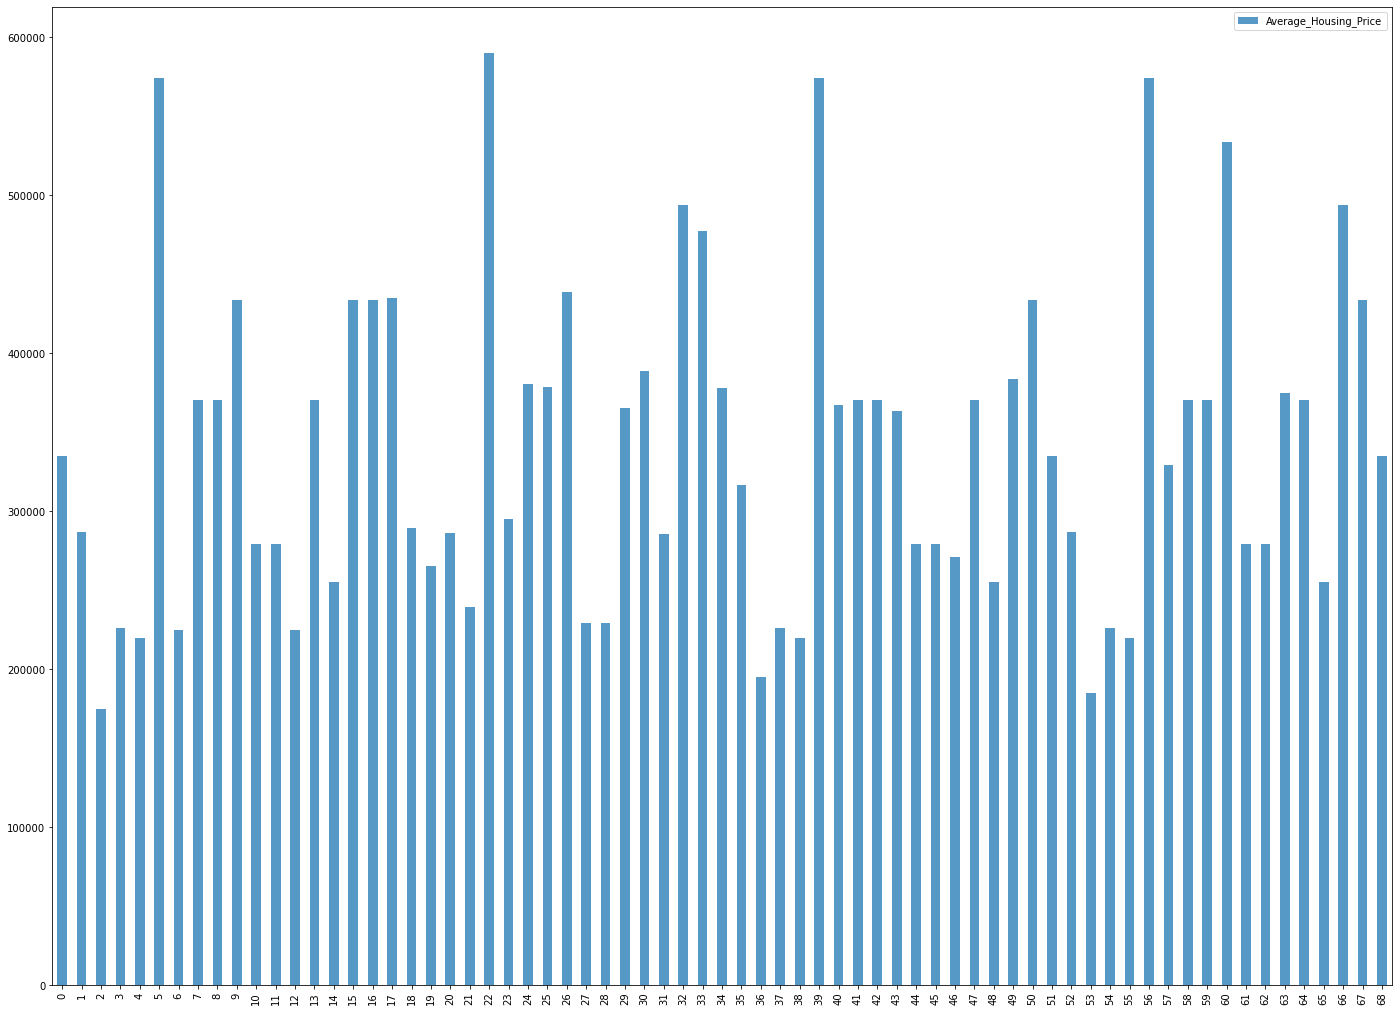

In [89]:
NorthVancouver_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

### School Rating by Clusters

In [82]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [90]:
new_NorthVancouver=NorthVancouver_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
NorthVancouver_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8
                                                           ]})

In [91]:
NorthVancouver_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

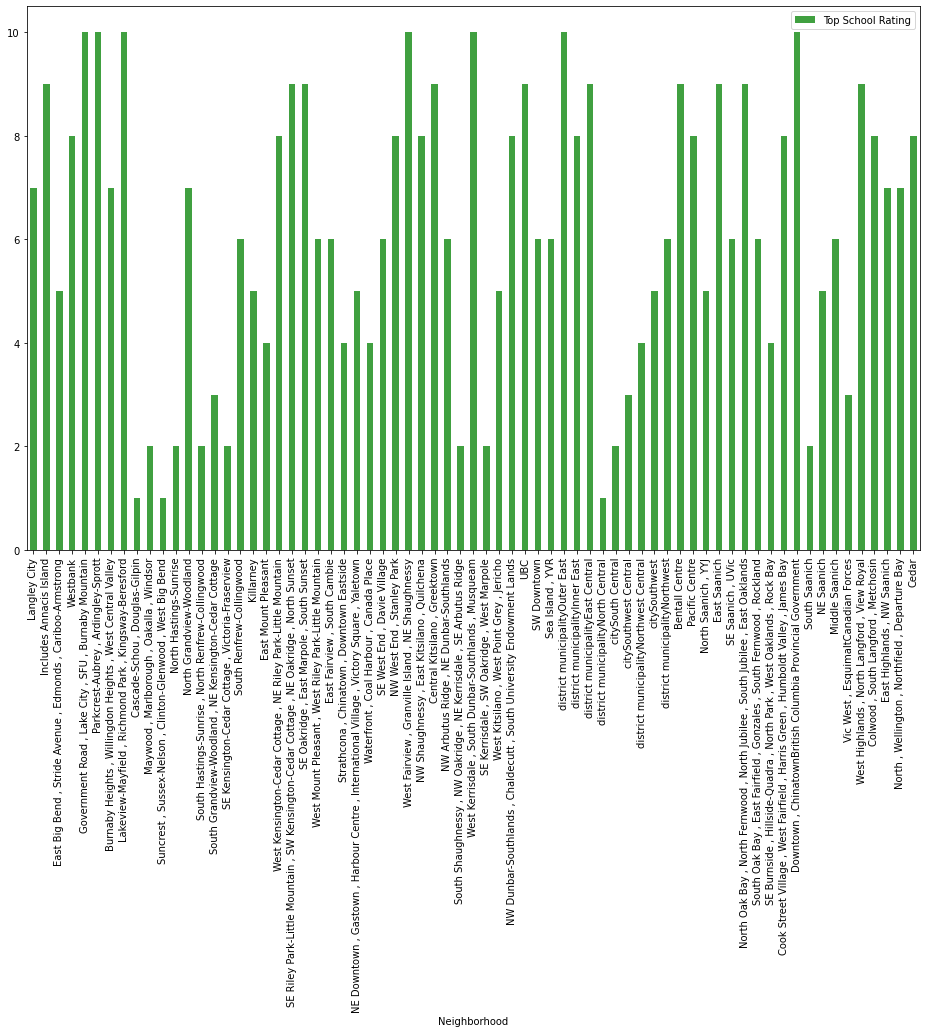

In [92]:
NorthVancouver_school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75);

Conclusion: In this project, using k-means cluster algorithm I separated the neighborhood into 10(Ten) different clusters and for 103 different lattitude and logitude from dataset, which have very-similar neighborhoods around them. Using the charts above results presented to a particular neighborhood based on average house prices and school rating have been made.